# Retention estimation for censored data
This intends to calculate the posterio distribution of the alpha and beta paramters from the shifted beta geometric distribution presented by __[Fader and Hardie](http://www.brucehardie.com/papers/021/sbg_2006-05-30.pdf)__.
I took the idea from __[Daniel Wietzenfied's site](http://danielweitzenfeld.github.io/passtheroc/blog/2015/01/19/s-b-g/)__, he's using pymc while I'm trying to use pymc3.

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
from scipy import optimize
import matplotlib.pyplot as plt
import theano.tensor as tt
from theano.tensor import _shared

The following data is the same Fader used in his example:

In [18]:
#example_data = np.array([1000, 869, 743, 653, 593, 551, 517, 491])
example_data = np.array([1000,472,395,362,342,329,320,317,303,294,286,281,278,276,276,269,262,257,254,252,250,252,246,242,238])
n = len(example_data)
example_data.shape

(25,)

In [19]:
def n_lost(data):
    lost = [None]
    for i in range(1, len(data)):
        lost.append(data[i - 1] - data[i])
    return lost

example_data_n_lost = n_lost(example_data)
data = np.asarray((example_data, example_data_n_lost))

In [5]:
# This block DOESN'T WORK, keeping it to know what NOT to do
def P_T_is_t(active, alpha, beta):
    p = np.array([None, alpha / (alpha + beta)])
    for t in range(2, num_periods):
        pt = ((beta + t - 2) / (alpha + beta + t - 1)) * p[t-1]
        p = np.append(p,pt)
    return p

def survival_function(active, alpha, beta):
    p = P_T_is_t(active, alpha, beta)
    s = np.array([None, 1 - p[1]])
    for t in range(2, num_periods):
        s = np.append(s, s[t-1] - p[t])
    return s

def logpx(value, alpha, beta):

    active = value[0,:]
    lost = value[1,:]
    
    # Those who've churned along the way...
    p = P_T_is_t(active, alpha, beta)
    died = np.multiply(np.log(p[1:]), lost[1:])
    
    # and those still active in last period
    sf = survival_function(active, alpha, beta)
    still_active = np.log(sf[-1]) * active[-1]
    return  sum(died) + still_active

with pm.Model() as model:
    alpha = pm.Uniform('alpha', 0.00001, 1000.0)
    beta = pm.Uniform('beta', 0.00001, 1000.0)
    num_periods = len(example_data)


    retention = pm.DensityDist('retention', logpx, observed={'value':data, 'alpha':alpha, 'beta': beta})
    print_alpha = tt.printing.Print('alpha')(alpha)
    print_beta = tt.printing.Print('beta')(beta)
    trace = pm.sample(10000, step=pm.Metropolis())
    burned_trace = trace[3000:]

100%|███████████████████████████████████| 10000/10000 [00:44<00:00, 226.99it/s]


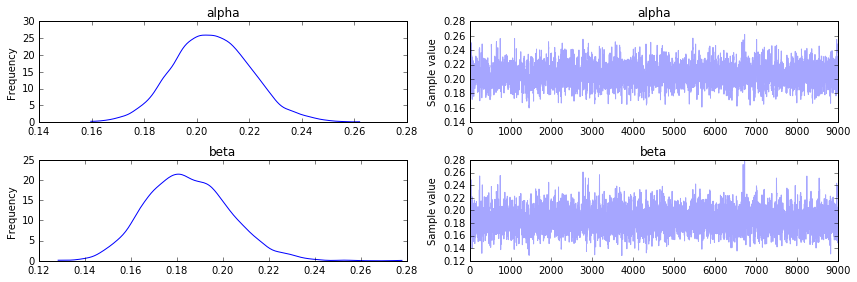

In [20]:
# This case DO WORK, it uses Theano
with pm.Model() as model:
    alpha = pm.Uniform('alpha', 0.00001, 1000.0, testval=1)
    beta = pm.Uniform('beta', 0.00001, 1000.0, testval=1)

    p = [0., alpha / (alpha + beta)]
    s = [0., 1 - p[1]]
    for t in range(2, n):
        pt = ((beta + t - 2) / (alpha + beta + t - 1)) * p[t-1]
        p.append(pt)
        s.append(s[t-1] - p[t])
    p = tt.stack(p)
    s = tt.stack(s)
    
    def logp(value):
        active = value[0,:]
        lost = value[1,:]

        # Those who've churned along the way...
        died = tt.mul(tt.log(p[1:]), lost[1:])

        # and those still active in last period
        still_active = tt.log(s[-1]) * active[-1]
        return  tt.sum(died) + still_active

    retention = pm.DensityDist('retention', logp, observed=data)
    trace = pm.sample(10000, step=pm.NUTS())
    burned_trace = trace[1000:]
_=pm.traceplot(burned_trace)

In [12]:
trace['alpha'].mean()

0.74021453879068067

In [13]:
trace['beta'].mean()

4.3751141122274362

## Print results and credible intervals
Now I'll rebuild the retention curve, along with its 95% credible interval

In [14]:
from scipy.stats.mstats import mquantiles
qs = mquantiles(trace['alpha'], [0.025, 0.975], axis=0)
print(qs)

[ 0.53805031  1.06369975]


In [15]:
import scipy.special as ss
a = trace['alpha'].mean()
b = trace['beta'].mean()
estimation_days = np.array((range(1,100)))
rebuilt_retention = ( np.exp(ss.gammaln(a) + ss.gammaln(b+estimation_days) - ss.gammaln(a+b+estimation_days)) / np.exp(ss.gammaln(a) + ss.gammaln(b) - ss.gammaln(a+b)))

a =  mquantiles(trace['alpha'], [0.025, 0.975], axis=0)[0]
b =  mquantiles(trace['beta'], [0.025, 0.975], axis=0)[0]
rebuilt_retention_l = ( np.exp(ss.gammaln(a) + ss.gammaln(b+estimation_days) - ss.gammaln(a+b+estimation_days)) / np.exp(ss.gammaln(a) + ss.gammaln(b) - ss.gammaln(a+b)))

a =  mquantiles(trace['alpha'], [0.025, 0.975], axis=0)[1]
b =  mquantiles(trace['beta'], [0.025, 0.975], axis=0)[1]
rebuilt_retention_h = ( np.exp(ss.gammaln(a) + ss.gammaln(b+estimation_days) - ss.gammaln(a+b+estimation_days)) / np.exp(ss.gammaln(a) + ss.gammaln(b) - ss.gammaln(a+b)))


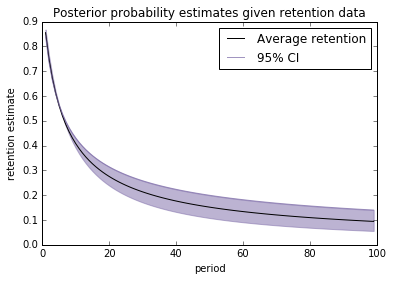

In [16]:
plt.plot(estimation_days, rebuilt_retention, '-', color = 'black', label="Average retention")
plt.plot(estimation_days, rebuilt_retention_l, label="95% CI", color="#7A68A6", alpha=0.7)
plt.fill_between(estimation_days, y1= rebuilt_retention_l, y2= rebuilt_retention_h, alpha=0.5, color="#7A68A6")
plt.legend(loc="upper right")

plt.xlabel("period")
plt.ylabel("retention estimate")
plt.title("Posterior probability estimates given retention data");

plt.show()